# Anomalieerkennung in Zeitreihen


### Quellen

Ausgangspunkt für dieses Notebook war die [Dokumentation](https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html) von SciKit-Learn.

Dieses Notebook verwendet eine [One-Class Suport Vector Machine(SVM)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) zur Anomalieerkennung in einer univariaten Zeitreihe aus dem [NAB](https://github.com/numenta/NAB)-Projekt.

Die One-Class SVM ist ein unüberwachter Lernalgorithmus und wird hier mit nicht-linearem Kernel eingesetzt.

## Setup

In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler

## Daten Laden

Die Daten wurden zuvor von GitHub geladen und liegen als `csv` Datei vor.

In [32]:
file_path = "datasets/univariate_machine_temp/machine_temperature_system_failure.csv"

temp_time_data = pd.read_csv(file_path, parse_dates=True, index_col="timestamp")


Kurze Prüfung der Datenstruktur

In [33]:

print(temp_time_data.head())


                         value
timestamp                     
2013-12-02 21:15:00  73.967322
2013-12-02 21:20:00  74.935882
2013-12-02 21:25:00  76.124162
2013-12-02 21:30:00  78.140707
2013-12-02 21:35:00  79.329836


Einige statistische Informationen zur Verteilungung der Daten

In [34]:
print(temp_time_data.describe())

              value
count  22695.000000
mean      85.926498
std       13.746912
min        2.084721
25%       83.080078
50%       89.408246
75%       94.016252
max      108.510543


Visualisierung der Daten

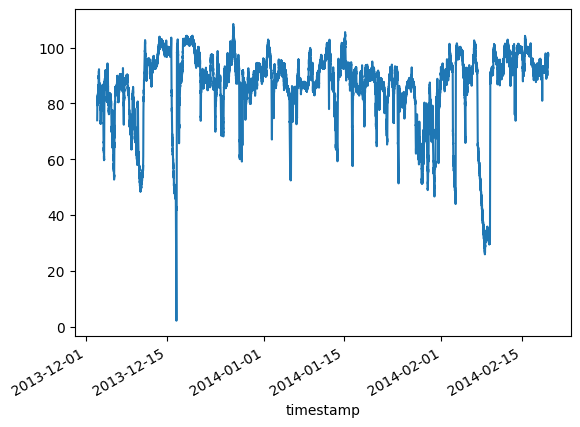

In [35]:
fig, ax = plt.subplots()
temp_time_data.plot(legend=False, ax=ax)
plt.show()

## Vorbereitung der Daten

Für das Training werden die ersten beiden Wochen der Zeitreihe verwendet.


In [36]:
start_time = pd.to_datetime('2013-12-02 00:00:00')
end_time = pd.to_datetime('2013-12-15 00:00:00')

temp_time_data_training = temp_time_data[(temp_time_data.index >= start_time) & 
                          (temp_time_data.index <= end_time)]

training_values = temp_time_data_training['value'].values
all_values = temp_time_data['value'].values

Hier visualisieren wir nochmals den Trainingsteil des Datensatzes.

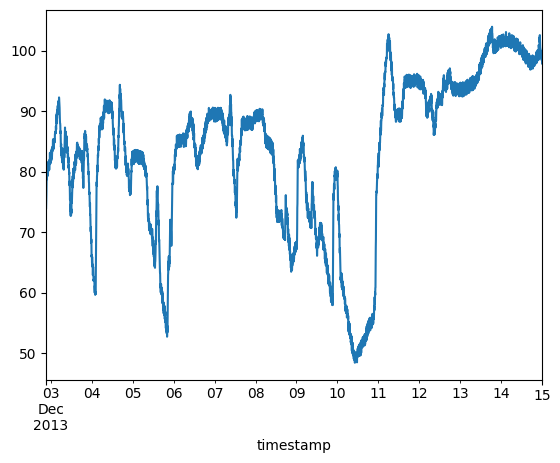

In [37]:
fig, ax = plt.subplots()
temp_time_data_training.plot(legend=False, ax=ax)
plt.show()

Bei der univariaten Analyse muss das Modell in die Lage versetzt werden, Entwicklungen in der Abfolge der Daten erkennen zu können. Daher erhält das Modell in jedem Schritt nicht nur einzelne Werte sondern jeweils Sequenzen von Einzelwerten als Input.

Die Zeitstempel sind in 5-Minuten-Intervallen erfasst, daher wird jeweils eine Sequenz von 288 Werten  betrachtet, was einem Tag entspricht (60 * 24 / 5 = 288).

In [38]:
TIME_STEPS = 288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

X_train = create_sequences(training_values)
X_test = create_sequences(all_values)

print("Shape of original training data:", training_values.shape)
print("Shape of sequential training data:", X_train.shape)
print("Shape of original full data:", all_values.shape)
print("Shape of sequential test data:", X_test.shape)

Shape of original training data: (3490,)
Shape of sequential training data: (3203, 288)
Shape of original full data: (22695,)
Shape of sequential test data: (22408, 288)


An dieser Stelle werden die Daten skaliert.

In [39]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Training

Wir nutzen ein fertiges Modell und daher direkt mit dem Training Beginnen. Der Gammawert bestimmt wieviel einzelne Punkte sich im Training auf das Modell auswirken und der Paramerter nu bestimmt die "Glättung" der erlernten Kurve, also wie genau das Modell lernt die Trainingsdaten zu reproduzieren.

 [Dokumentation](https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel)

In [40]:
clf = OneClassSVM(nu=0.01, kernel='rbf', gamma=0.01) 
clf.fit(X_train_scaled)


,kernel,'rbf'
,degree,3
,gamma,0.01
,coef0,0.0
,tol,0.001
,nu,0.01
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


## Inferenz

Nun kann das Modell zur Vorhersage genutzt werden.

Die Vorhersage für die jeweilige Sequenz wird in den ursprünglichen Daten dem jeweils letzten Punkt der Sequenz zugeordnet. Für die ersten (TIME_STEPS - 1) Punkte liegt keine vollständige Sequenz vor und sie liegen ohnehin in den Trainingsdaten, deshalb werden diese als normal angenommen.

In [41]:
# Vorhersage für Sequenzen
x_pred_sequences = clf.predict(X_test_scaled)

# Übertragung der Anomalie-Werte von den Sequenzen auf die Datenpunkte
x_pred_full = np.full(len(temp_time_data), 1, dtype=int)
x_pred_full[TIME_STEPS - 1:] = x_pred_sequences
temp_time_data['anomaly'] = x_pred_full

# Identifizieren aufeinanderfolgender Anomalie-Punkte
is_anomaly = temp_time_data['anomaly'] == -1

# Zusammenfassung zu Anomalie-Blöcken
anomaly_blocks = (is_anomaly.diff() != 0).cumsum()

# Zählen der aufeinanderfolgenden Anomalie-Punkte
temp_time_data['consecutive_count'] = is_anomaly.groupby(anomaly_blocks).cumsum()

# DataFrame, der nur die Punkte enthält, die Teil eines Anomalie-Blocks sind
anomalies = temp_time_data[temp_time_data['consecutive_count'] > 0]

print("Statistics for anomaly sequence lengths:")
print(anomalies['consecutive_count'].describe())

Statistics for anomaly sequence lengths:
count    2219.000000
mean      299.923389
std       216.239346
min         1.000000
25%       128.500000
50%       267.000000
75%       416.000000
max       866.000000
Name: consecutive_count, dtype: float64


Jetzt sollen die Daten als Overlay über die ursprünglichen Daten gelegt werden. Aufeinanderfolgende Anomalie-Punkte werden mit einer Farbskala markiert, um steigende Signifikanz zu verdeutlichen.

/tmp/ipykernel_8828/1572372916.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('plasma')


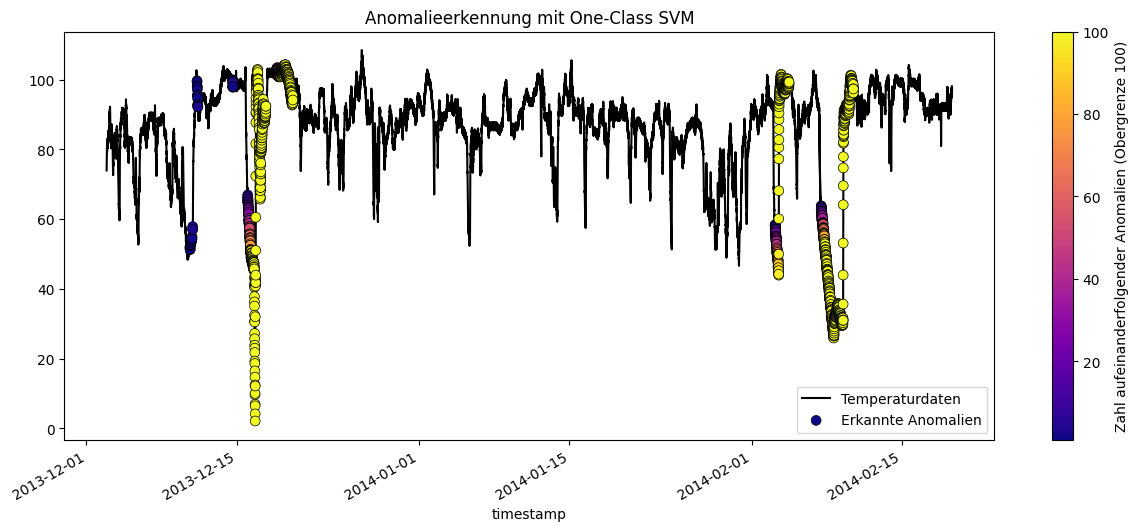

In [42]:
# Oberes Limit für Farbskala als maximale Signifikanz
COLORBAR_UPPER_LIMIT = 100

# Farbskala
cmap = plt.cm.get_cmap('plasma')

fig, ax = plt.subplots(figsize=(15, 6))
temp_time_data['value'].plot(legend=False, ax=ax, label='Temperaturdaten', color='black', zorder=1)

scatter = ax.scatter(
    anomalies.index, 
    anomalies['value'],
    c=anomalies['consecutive_count'], 
    cmap=cmap, 
    vmin=1, # Start der Farbskala
    vmax=COLORBAR_UPPER_LIMIT, # Obergrenze der Farbskala
    s=50,
    edgecolors='k',
    linewidths=0.5,
    label='Erkannte Anomalien',
    zorder=2
)

plt.legend()
plt.title('Anomalieerkennung mit One-Class SVM')
cbar = fig.colorbar(scatter)
cbar.set_label(f'Zahl aufeinanderfolgender Anomalien (Obergrenze {COLORBAR_UPPER_LIMIT})')
plt.show()

## Vergleich mit Referenzmodell und Wahrheitswerten

Zunächst laden wir die Daten von [einem der Ergbnis-Datensätze](https://github.com/numenta/NAB/blob/master/results/ARTime/realKnownCause/ARTime_machine_temperature_system_failure.csv) des NAB-Benchmarks und übernehmen daraus die Ground Truth-Werte. Die Werte sind binär, wobei 1 für eine Anomalie steht und 0 für einen normalen Punkt.

In [43]:
truth_file_path = "datasets/univariate_machine_temp/ARTime_machine_temperature_system_failure.csv" 

df_truth = pd.read_csv(truth_file_path, parse_dates=True, index_col="timestamp")

# Die Ground Truth Werte aus der Spalte label werden in den ursprünglichen Datensatz aufgenommen
temp_time_data.sort_index(inplace=True)
df_truth.sort_index(inplace=True)
df_combined = temp_time_data.join(df_truth[['label']])

# Möglicherweise fehlende Label werden mit 0 aufgefüllt (für "normal")
df_combined['label'].fillna(0, inplace=True)

/tmp/ipykernel_8828/2347506276.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['label'].fillna(0, inplace=True)


Hier nutzen wir das Metrics Feature von Scikit-Learn, um die Genauigkeit der Klassifizierung zu bewerten.

In [44]:
from sklearn.metrics import classification_report

# Ersten (TIME_STEPS - 1) Sequenzen werden von Vorhersagen und Ground Truth ausgenommen für den Vergleich
y_pred = df_combined['anomaly'].iloc[TIME_STEPS - 1:].values
y_true_original = df_combined['label'].iloc[TIME_STEPS - 1:].values

# Ground Truth-Label werden angepasst an die Ausgabe des Modells (-1, 1)
y_true = np.where(y_true_original == 1, -1, 1)

# Erzeugt einen Bericht zu Precision, recall und f1-score.
print("--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=['Anomalie (-1)', 'Normal (1)']))

--- Classification Report ---
               precision    recall  f1-score   support

Anomalie (-1)       0.49      0.48      0.48      2268
   Normal (1)       0.94      0.94      0.94     20164

     accuracy                           0.90     22432
    macro avg       0.72      0.71      0.71     22432
 weighted avg       0.90      0.90      0.90     22432



Jetzt ergänzen wir den vorherigen Graph mit der Farbskala noch um eine Markierung der Ground Truth-Werte.

/tmp/ipykernel_8828/214757813.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  starts = df_combined.index[is_true_anomaly & ~is_true_anomaly.shift(1).fillna(False)]
/tmp/ipykernel_8828/214757813.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ends = df_combined.index[is_true_anomaly & ~is_true_anomaly.shift(-1).fillna(False)]


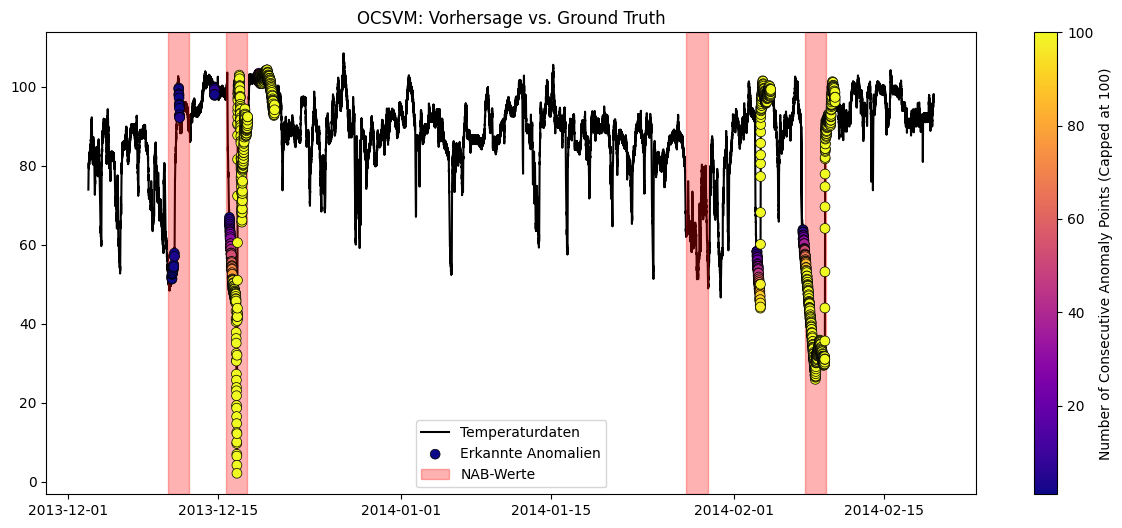

In [45]:
# Start und Ende der Anomalien werden aus den Label-Daten ermittelt
is_true_anomaly = df_combined['label'] == 1
starts = df_combined.index[is_true_anomaly & ~is_true_anomaly.shift(1).fillna(False)]
ends = df_combined.index[is_true_anomaly & ~is_true_anomaly.shift(-1).fillna(False)]

# Ursprünglicher Plot
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df_combined.index, df_combined['value'], label='Temperaturdaten', color='black', zorder=1)

predicted_anomalies = df_combined[df_combined['consecutive_count'] > 0]

scatter = ax.scatter(
    predicted_anomalies.index, 
    predicted_anomalies['value'], 
    c=predicted_anomalies['consecutive_count'], 
    cmap=cmap, 
    vmin=1,
    vmax=COLORBAR_UPPER_LIMIT,
    s=50,
    edgecolors='k',
    linewidths=0.5,
    label='Erkannte Anomalien',
    zorder=3
)

# Tatsächliche Anomalie-Abschnitte werden farblich markiert
if not starts.empty and not ends.empty:
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, color='red', alpha=0.3, label='_nolegend_')
ax.fill_between([], [], color='red', alpha=0.3, label='NAB-Werte')


ax.legend()
ax.set_title('OCSVM: Vorhersage vs. Ground Truth')
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label(f'Number of Consecutive Anomaly Points (Capped at {COLORBAR_UPPER_LIMIT})')
plt.show()

Aus der wissenschaftlichen Veröffentlichung zum NAB: 
"The first anomaly was a planned shutdown. The third anomaly is a catastrophic system failure. The second anomaly, a subtle but observable change in the behavior, indicated the actual onset of the problem that led to the eventual system failure."

<img src="ground_truth.png" alt="Alt text" width="800">